Scraping from Booking, Kayak and Momondo - Arup Sarkar

# 🚀 `READ ME`

---



# ⭐* !!!!!This Code requires dependencies, if you are running it please place data_format.py and file_writer.py in the temporary session before running!!!!*⭐


---




***Installing the libraries needed for selenium and selenium stealth, since colab doesn't allow chrome driver to auotmate chrome like a local machine can to be used as is, we need to use headless mode of browser. For that we require stealth selenium.***

In [ ]:
!apt update
!apt install chromium-chromedriver
!pip install selenium
!pip install selenium-stealth
!wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb && apt install ./google-chrome-stable_current_amd64.deb

Scrapping data from booking.com using headless browser mode of selenium.

In [7]:
from selenium import webdriver
from selenium_stealth import stealth
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_format import FlightInformation #NOTE : : : : : !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!This is custom data_format.py file used as a dependency!!!!!!!!!!!!!!!!!!!
from file_writer import Source #NOTE : : : : : !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!This is custom file_writer file used as a dependency!!!!!!!!!!!!!!!!!!!


def press_button_pagination(driver): #This function generates virual mouse clicks to navigate through pages, this will be called once we start scraping the first page.
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator a.moreButton")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
#run Selenium in headless mode and no sandbx.
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
#Limited resource problems by using restricted shm usage.
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
#Open Browser in maximized mode
    options.add_argument("start-maximized")
#Disable infobars
    options.add_argument("disable-infobars")
#Disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,                                                         #Making the driver work in stealth mode using intel renderer.
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "div.resultsPaginator"))
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit() #stopping the driver.


def find_text_elements(list_element, selector, element="span"):   #text elements finder.
    return list_element.find(element, selector).text


def return_transit_details(transits):     #layover calulator.
    for list_element in transits:
        depart_list = list_element.find_all("div", "col-field time depart")
        depart_location = find_text_elements(depart_list[0], "bottom", "div")
        arrival_list = list_element.find_all("div", "col-field time return")
        arrival_location = find_text_elements(arrival_list[0], "bottom", "div")
        transit_location = None
        airport_name = None
        layover_time = None

        if depart_location == "HEL":                                              #setting depart location Helsinki, sorting out direct flights and transit flights.
            flight_stop = list_element.find("div", "bottom stops").text
            direct_flight = flight_stop == "\nnonstop "
            if not direct_flight:
                transit_location = find_text_elements(
                    list_element=list_element, selector="js-layover"
                )
                transit_details = list_element.find("span", "js-layover")["title"]
                transit_time = transit_details.split("layover,")
                layover_time = transit_time[0]
                # print("Layover time", layover_time[0])
                pattern = r"<b>(.*?)</b>"
                match = re.findall(pattern, transit_details)
                airport_name = match[0]
                # print("Transit airport:", airport_name)
            depart_time = find_text_elements(
                list_element=list_element, selector="depart-time base-time"
            )
            arrival_time = find_text_elements(
                list_element=list_element, selector="arrival-time base-time"
            )
            duration_div = list_element.find("div", "col-field duration")
            flight_duration = duration_div.find("div", "top").text
            # print("Depart", depart_time)
            # print("Arrival", arrival_time)
            return (
                "HEL",
                arrival_location,
                direct_flight,
                transit_location,
                layover_time,
                airport_name,
                depart_time,
                arrival_time,
                flight_duration,
            )


def find_flights(flight_list):                    #finding airlines and scrapping flight details from within.
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "flight")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find("div", "section disclosures")
        # print(airlines_div)
        if airlines_div is not None:
            airlines_name = find_text_elements(airlines_div, "section operators", "div")
            print("airlines_name", airlines_name.split("\nOperated by ")[1])
            price = None
            booking_dropdown = flights.find_all("div", "multibook-dropdown")
            price = find_text_elements(booking_dropdown[0], "price-text", "span")
            source = find_text_elements(booking_dropdown[0], "name-only-text", "span")
            flight_info = FlightInformation(
                airline_names=airlines_name.split("\nOperated by ")[1],
                departure_time=flight[6],
                arrival_time=flight[7],
                departure_location=flight[0],
                arrival_destination=flight[1],
                flight_duration=flight[-1],
                direct_flight=flight[2],
                layover_time=flight[4],
                transit_location=flight[3],
                transit_airport=flight[5],
                flight_price=price.split("\n")[1],
                source=source.split("\n")[1],
                scraped_website="Booking.com",
            )
            list_structured_flight.append(flight_info)
    return list_structured_flight


class Booking_Com(Source):                                                                      #setting a class to call to parse the url into the function above where driver is written.
    def __init__(self):
        url = "https://booking.kayak.com/flights/HEL-NYC/2023-10-26/2023-11-02?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="inner-grid keel-grid")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":            #saving the scraped data into a csv file.
    f = Booking_Com()
    f.save_file()


Scraping Website
airlines_name Finnair 
airlines_name SmartLynx 
airlines_name Finnair, American Airlines 
airlines_name SAS Connect 
airlines_name Finnair 
airlines_name Finnair, American Airlines 
airlines_name SmartLynx 
airlines_name Finnair 
airlines_name Jettime A/S 
airlines_name SAS Connect 
airlines_name Finnair 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Jettime A/S 
airlines_name Finnair, American Airlines 
airlines_name American Airlines 
airlines_name Xfly, SmartLynx 
airlines_name Finnair 
airlines_name SAS Connect 
airlines_name Finnair 
airlines_name SAS Connect 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair, American Airlines 
airlines_name Finnair 
airlines_name Jettime A/S 
airlines_name Finnair 
airlines_name Finnair, American Airlines 
airlines_name SAS Connect, Xfly, SmartLynx 
airlines_name SAS Connect, Xfly, SmartLynx 
airlines_name SAS Connect, Xfl

***Kayak Scrapper, similar to booking.com***

In [8]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_format import FlightInformation
from file_writer import Source


def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
#run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
#overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
#open Browser in maximized mode
    options.add_argument("start-maximized")
#disable infobars
    options.add_argument("disable-infobars")
#disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Kayak",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight


class Kayak(Source):
    def __init__(self):
        url = (
            "https://kayak.com/flights/HEL-NYC/2023-10-26/2023-11-02?sort=bestflight_a"
        )
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    f = Kayak()
    f.save_file("a")


Message: element click intercepted: Element <div role="button" tabindex="0" class="ULvh-button show-more-button">...</div> is not clickable at point (422, 24). Other element would receive the click: <div role="button" tabindex="0" class="NITa NITa-location-inline NITa-hasValue NITa-mod-multi-values">...</div>
  (Session info: headless chrome=117.0.5938.132)
Stacktrace:
#0 0x590a67b8c6b3 <unknown>
#1 0x590a678621e7 <unknown>
#2 0x590a678af65d <unknown>
#3 0x590a678ad9fd <unknown>
#4 0x590a678ab7b8 <unknown>
#5 0x590a678aa827 <unknown>
#6 0x590a6789f4f9 <unknown>
#7 0x590a678cb0c2 <unknown>
#8 0x590a6789ef16 <unknown>
#9 0x590a678cb28e <unknown>
#10 0x590a678e4322 <unknown>
#11 0x590a678cae93 <unknown>
#12 0x590a6789d934 <unknown>
#13 0x590a6789e71e <unknown>
#14 0x590a67b51cb8 <unknown>
#15 0x590a67b55bf0 <unknown>
#16 0x590a67b6019c <unknown>
#17 0x590a67b56808 <unknown>
#18 0x590a67b2327f <unknown>
#19 0x590a67b7ae88 <unknown>
#20 0x590a67b7b059 <unknown>
#21 0x590a67b8b843 <unknown>


***Momondo, similar way to scrap***

In [9]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup as bs
import re
from data_format import FlightInformation
from file_writer import Source


def press_button_pagination(driver):
    try:
        more_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        more_button.click()
        WebDriverWait(driver, 30)
    except Exception as e:
        print(str(e))


def initialize_driver(url):
    options = webdriver.ChromeOptions()
#run Selenium in headless mode
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
#overcome limited resource problems
    options.add_argument('--disable-dev-shm-usage')
    options.add_argument("lang=en")
#open Browser in maximized mode
    options.add_argument("start-maximized")
#disable infobars
    options.add_argument("disable-infobars")
#disable extension
    options.add_argument("--disable-extensions")
    options.add_argument("--incognito")
    options.add_argument("--disable-blink-features=AutomationControlled")

    driver = webdriver.Chrome(options=options)

    stealth(driver,
        languages=["en-US", "en"],
        vendor="Google Inc.",
        platform="Win32",
        webgl_vendor="Intel Inc.",
        renderer="Intel Iris OpenGL Engine",
        fix_hairline=True,
        )
    driver.get(
        url,
    )
    for _ in range(10):
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located(
                (By.CSS_SELECTOR, "div.resultsPaginator div.show-more-button")
            )
        )
        press_button_pagination(driver=driver)
    webpage = driver.page_source
    return driver, webpage


def quit_driver(driver):
    driver.quit()


def find_text_elements(list_element, selector, element="span"):
    return list_element.find(element, selector).text


def return_transit_details(transits):
    flight = transits[0]
    flight_time = flight.find("div", "vmXl vmXl-mod-variant-large")
    flight_time_spans = flight_time.find_all("span")
    departure_time, arrival_time = flight_time_spans[0].text, flight_time_spans[2].text
    airport_names = flight.find_all("span", "EFvI-ap-info")
    depart_location, arrival_location = airport_names[0].text, airport_names[1].text
    stop_div = flight.find("div", "JWEO")
    stop_text = stop_div.find("span", "JWEO-stops-text").text
    airport_name = None
    transit_location = None
    layover_time = None
    multiple_stops = stop_text != "direct"
    # print(multiple_stops)
    flight_duration = flight.find_all("div", "vmXl vmXl-mod-variant-default")[1].text
    if multiple_stops:
        stop = stop_div.find("div", "c_cgF c_cgF-mod-variant-default")
        span_element = stop.find_all("span")
        pattern = r"<b>(.*?)</b>"
        # print(span_element)
        if len(span_element) > 0:
            airport_name = re.findall(pattern, span_element[1]["title"][0])
            transit_location = span_element[1].text
            layover_time = span_element[1]["title"].split(" layover,")[0]
    return (
        depart_location,
        arrival_location,
        multiple_stops,
        transit_location,
        layover_time,
        None,
        departure_time,
        arrival_time,
        flight_duration,
    )


def find_flights(flight_list):
    list_structured_flight = list()
    for flights in flight_list:
        transit_flights = flights.find_all("li", "hJSA-item")
        flight = return_transit_details(transits=transit_flights)
        airlines_div = flights.find_all("div", "J0g6-labels-grp")
        price = flights.find("div", "f8F1-price-text").text
        airline_name = None
        if len(airlines_div) != 0:
            airlines = airlines_div[0].find("div", "J0g6-operator-text")
            if airlines:
                airline_name = airlines.text.split("Operated by")[1]
                print(airline_name)
        flight_info = FlightInformation(
            airline_names=airline_name,
            departure_time=flight[6],
            arrival_time=flight[7],
            departure_location=flight[0],
            arrival_destination=flight[1],
            flight_duration=flight[-1],
            direct_flight=flight[2],
            layover_time=flight[4],
            transit_location=flight[3],
            transit_airport=flight[5],
            flight_price=price,
            source=None,
            scraped_website="Momondo",
        )
        list_structured_flight.append(flight_info)
    return list_structured_flight


class Momondo(Source):
    def __init__(self):
        url = "https://www.momondo.com/flight-search/HEL-NYC/2023-10-28/2023-11-04?sort=bestflight_a"
        self.driver, self.website = initialize_driver(url)

    def scrape(self):
        print("Scraping Website")
        webpage = self.website
        soup = bs(webpage, "html.parser")
        html = soup.prettify()
        flight_list = soup.find_all(class_="nrc6")
        flights = find_flights(flight_list=flight_list)
        quit_driver(self.driver)
        return flights


if __name__ == "__main__":
    m = Momondo()
    m.save_file("a")


Scraping Website
 Finnair, American Airlines
 Finnair, British Airways
 Finnair, British Airways
 Delta, KLM
 Finnair
 Finnair
 American Airlines
 KLM Cityhopper, KLM
 KLM Cityhopper, Delta
 KLM Cityhopper For KLM Royal Dutch Airli, Delta, KLM
 American Airlines
 KLM Cityhopper, Delta
 Finnair
 Lufthansa CityLine
 Finnair
 Finnair
 Finnair
 United Airlines, Lufthansa CityLine
 Finnair, American Airlines
 Finnair, American Airlines
 Finnair, British Airways
 Finnair, American Airlines
 Finnair, Iberia For Finnair, American Airlines
 American Airlines
 Finnair, American Airlines
 Finnair, American Airlines
 Finnair, American Airlines
 Lufthansa CityLine
 United Airlines, Lufthansa CityLine
 Delta, KLM, Republic Airways Delta Connection For Delta Air Lines
 Finnair, American Airlines
 Finnair
 Iberia For Finnair, American Airlines
 Finnair, American Airlines
 Finnair, Iberia For Finnair, American Airlines
 Finnair, British Airways
 Finnair
 Finnair, American Airlines
 Finnair, American Ai

***Once we have the CSV from all the data above we try for EDA***

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

**Price Distribution**

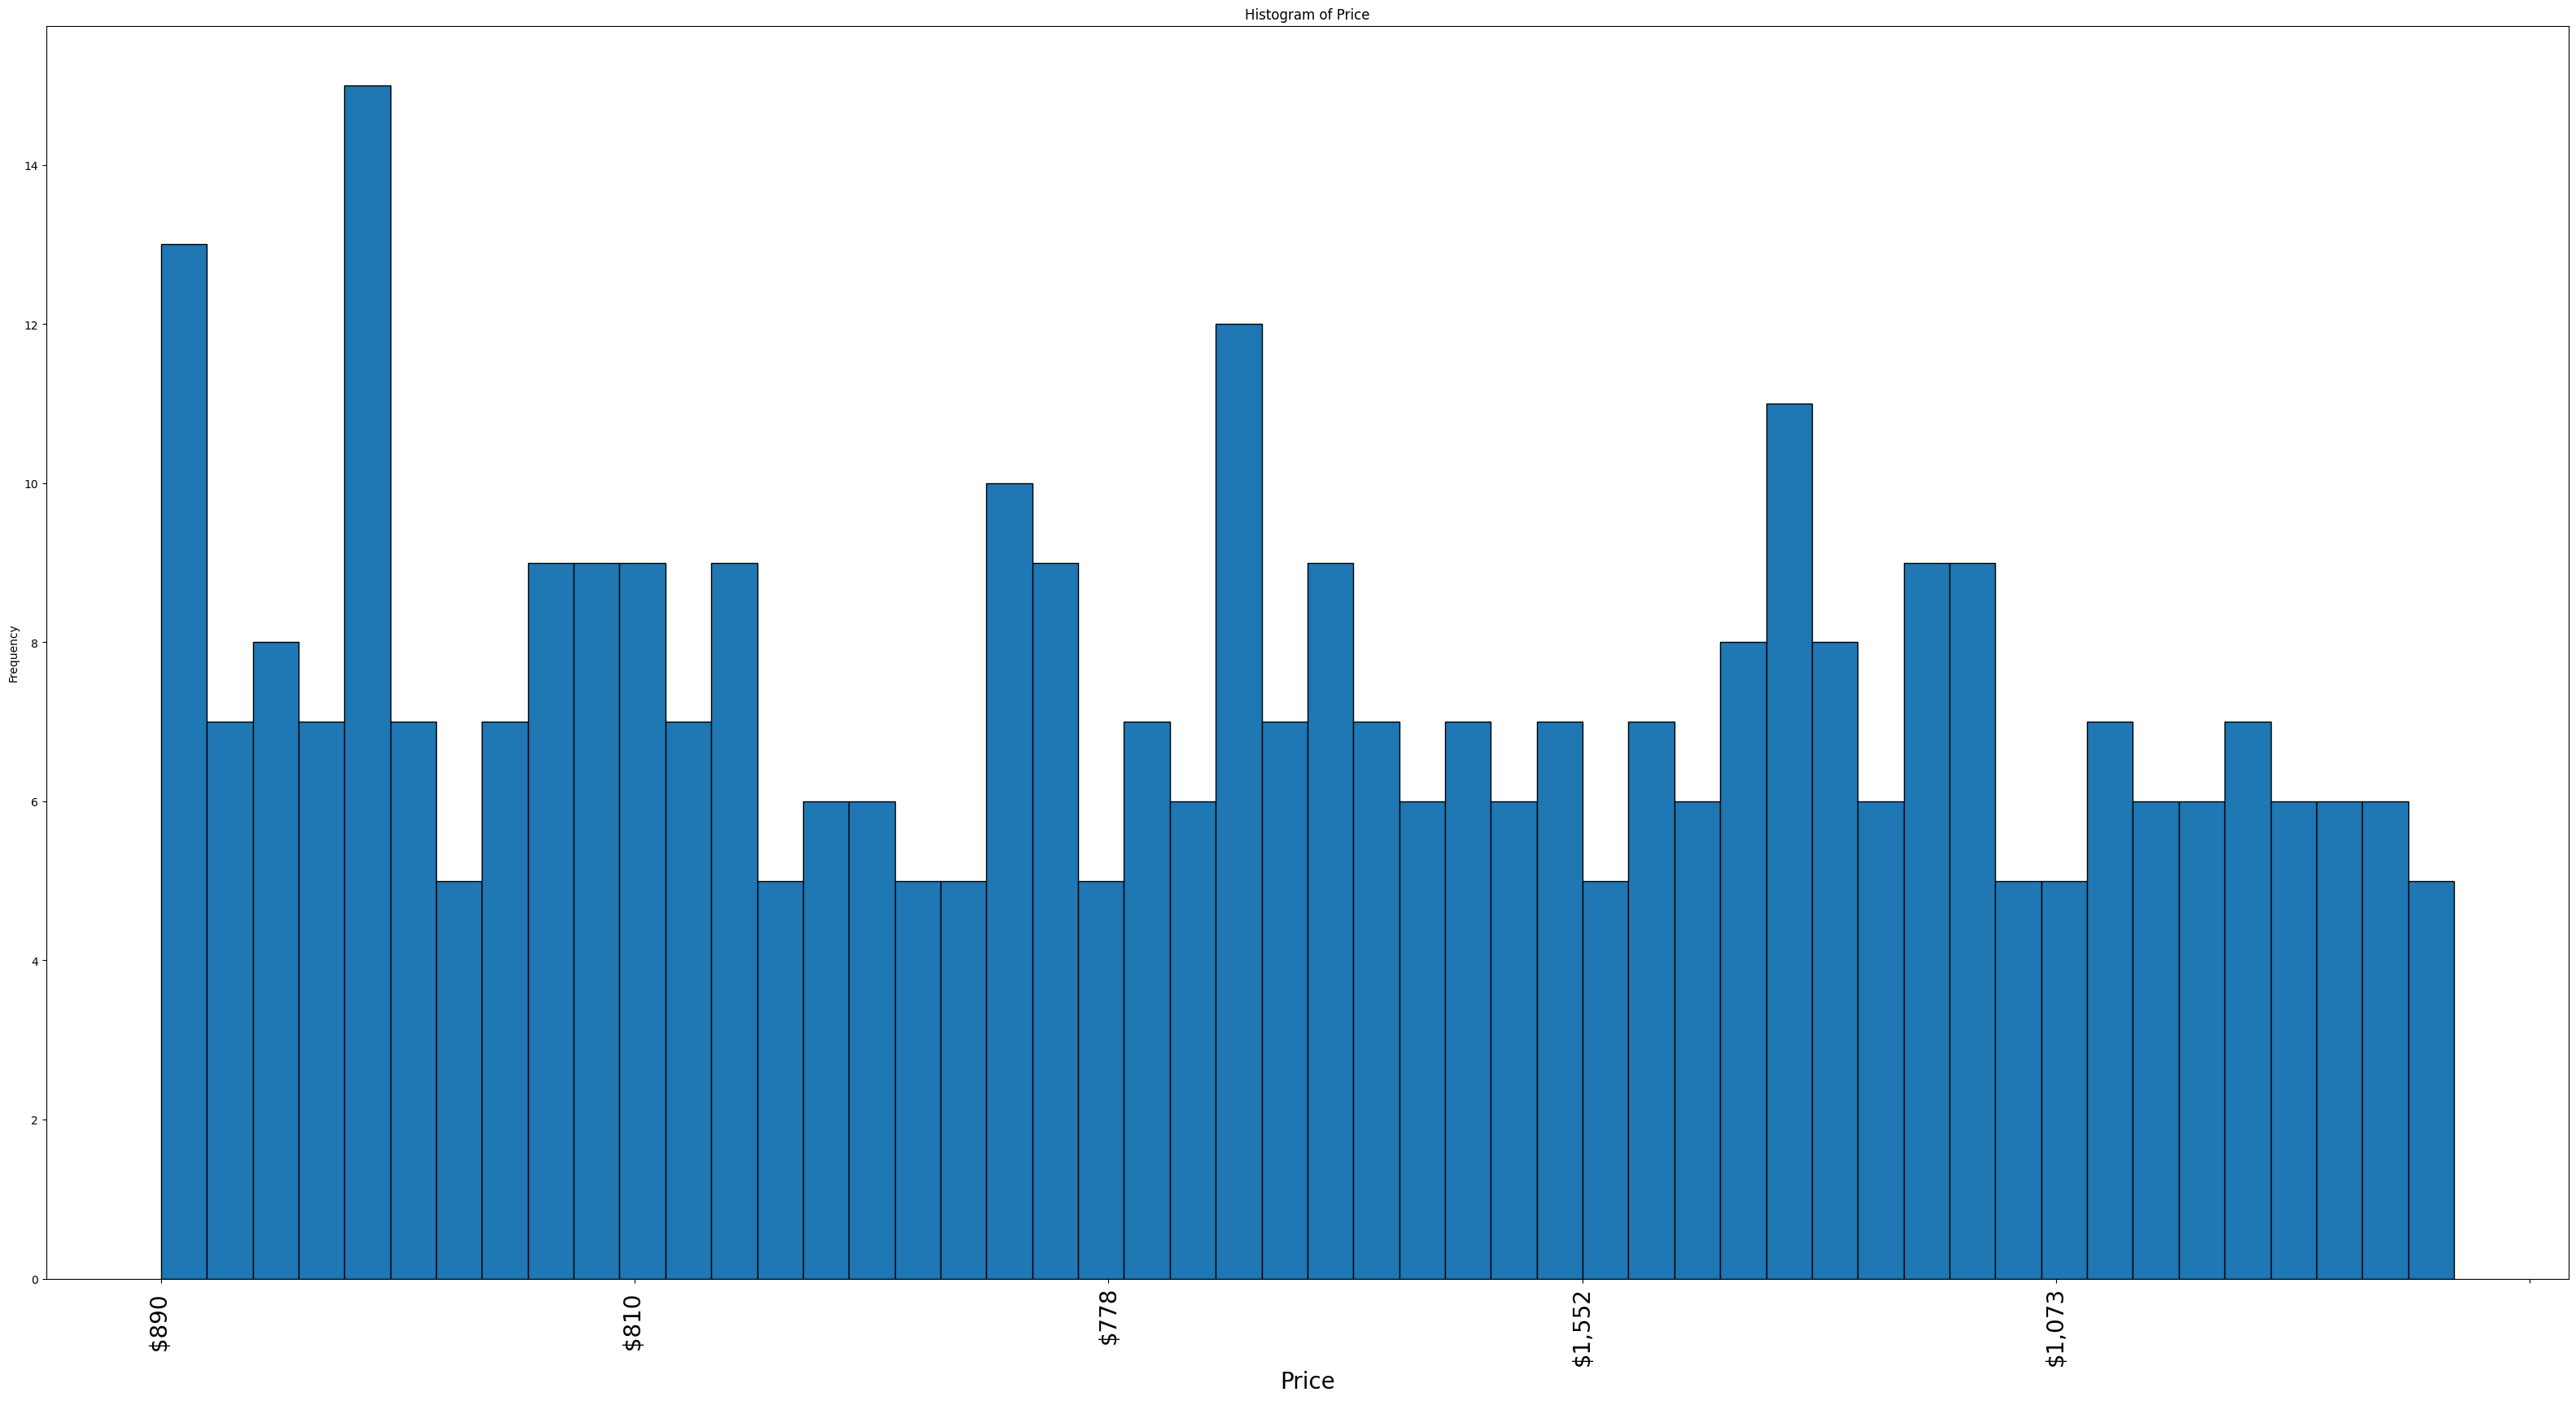

In [30]:
df = pd.read_csv('flight.csv')
column_name = 'Price'

plt.figure(figsize=(40, 20))

plt.hist(df[column_name], bins=50, edgecolor='k')  # Adjust the number of bins as needed
plt.xlabel(column_name, fontsize=20)
plt.ylabel('Frequency')
plt.title(f'Histogram of {column_name}')
plt.xticks(rotation=90, fontsize=20)
plt.gca().xaxis.set_major_locator(ticker.AutoLocator())
plt.show()

**Airlines Distribution for the day**

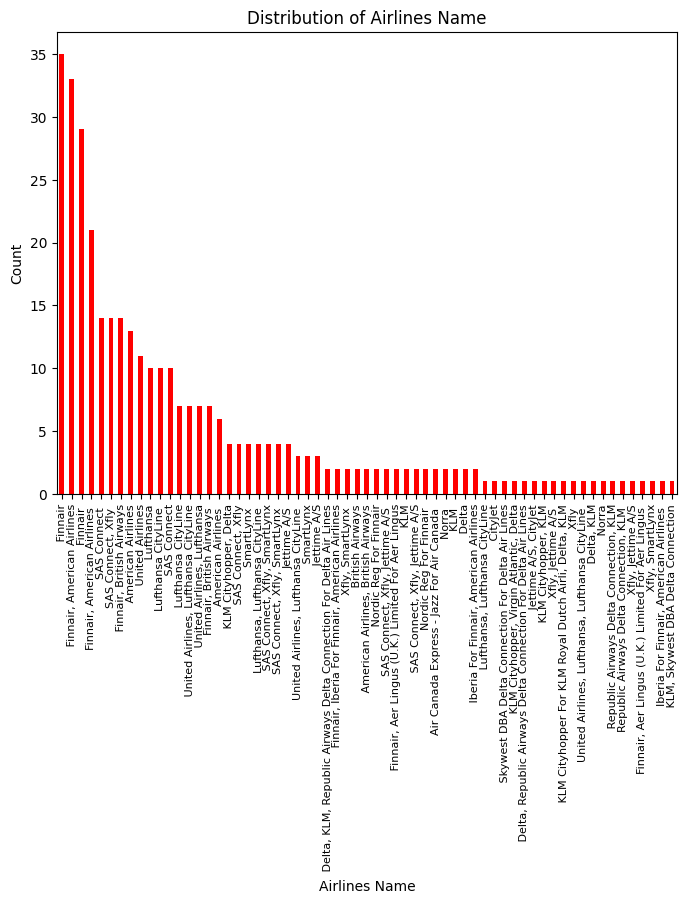

In [46]:
column_name = 'Airlines Name'

category_counts = df[column_name].value_counts()

plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='red')
plt.xlabel(column_name)
plt.ylabel('Count')
plt.title(f'Distribution of {column_name}')
plt.xticks(rotation=90, fontsize=8)
plt.show()

***Here we try to show the time taken by each flight per Airlines***

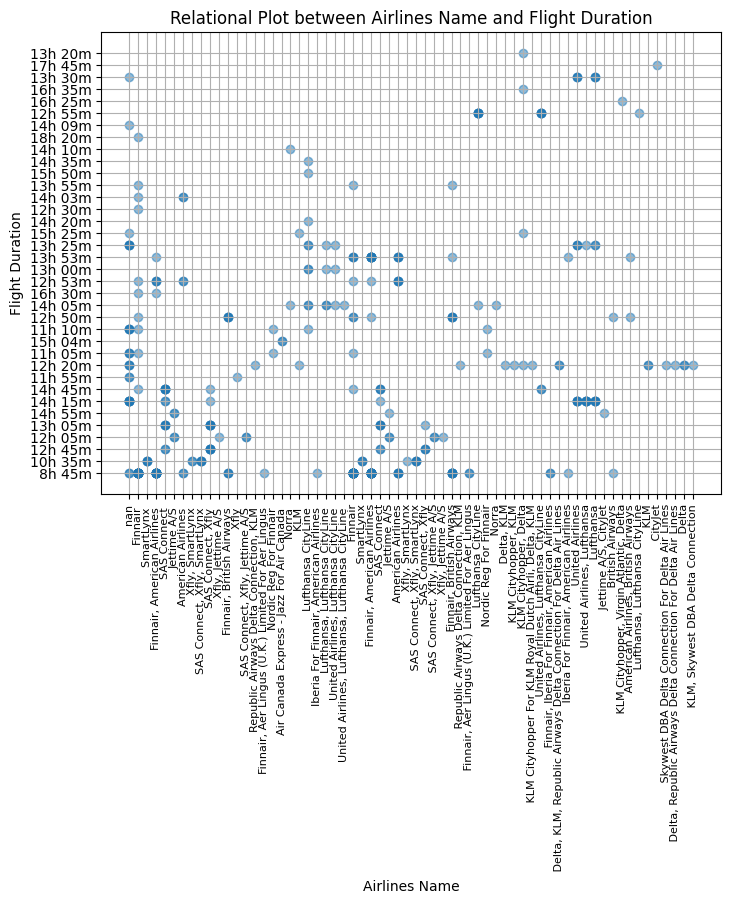

In [52]:
import seaborn as sns
column1_name = 'Airlines Name'
column2_name = 'Flight Duration'

df['Category1_numeric'] = pd.factorize(df[column1_name])[0]
df['Category2_numeric'] = pd.factorize(df[column2_name])[0]
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(df['Category1_numeric'], df['Category2_numeric'], alpha=0.5)  # Alpha controls transparency
plt.xlabel(column1_name)
plt.ylabel(column2_name)
plt.title(f'Relational Plot between {column1_name} and {column2_name}')
plt.xticks(ticks=df['Category1_numeric'].unique(), labels=df[column1_name].unique(), rotation=90, fontsize=8)
plt.yticks(ticks=df['Category2_numeric'].unique(), labels=df[column2_name].unique())
plt.grid(True)  # Add grid lines (optional)
plt.show()




In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


In [3]:
# Replace 'your_data.csv' with the path to your CSV file
df = pd.read_csv('flight.csv')


**Statistical overview of the data**

In [10]:
print(df.head())

# Get summary statistics for numerical columns
print(df.describe())

# Check for missing values
print(df.isnull().sum())

         Airlines Name         Departure Time Arrival Time Departure Location  \
0                     Finnair       5:20          7:05             HEL          
1                   SmartLynx       9:20         12:55             HEL          
2  Finnair, American Airlines       5:20          7:05             HEL          
3                 SAS Connect       7:10         12:55             HEL          
4                     Finnair       5:20          7:05             HEL          

  Arrival Destination Flight Duration  Direct FLight Layover Time  \
0          JFK              8h 45m          True            NaN     
1          EWR             10h 35m         False            1h      
2          JFK              8h 45m          True            NaN     
3          EWR             12h 45m         False        3h 15m      
4          JFK              8h 45m          True            NaN     

  Transit Location  Transit Airport    Price   Source Link Scraped Website  
0        NaN         

In [14]:
df = pd.read_csv('flight.csv')

column_x = 'Departure Time'
column_y = 'Price'
column_name = 'Price'

# Replace 'x' with an empty string in the specified column
df[column_name] = df[column_name].str.replace('$', '')

<ipython-input-14-659ced5562ab>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[column_name] = df[column_name].str.replace('$', '')


**Relation between departure time and price**

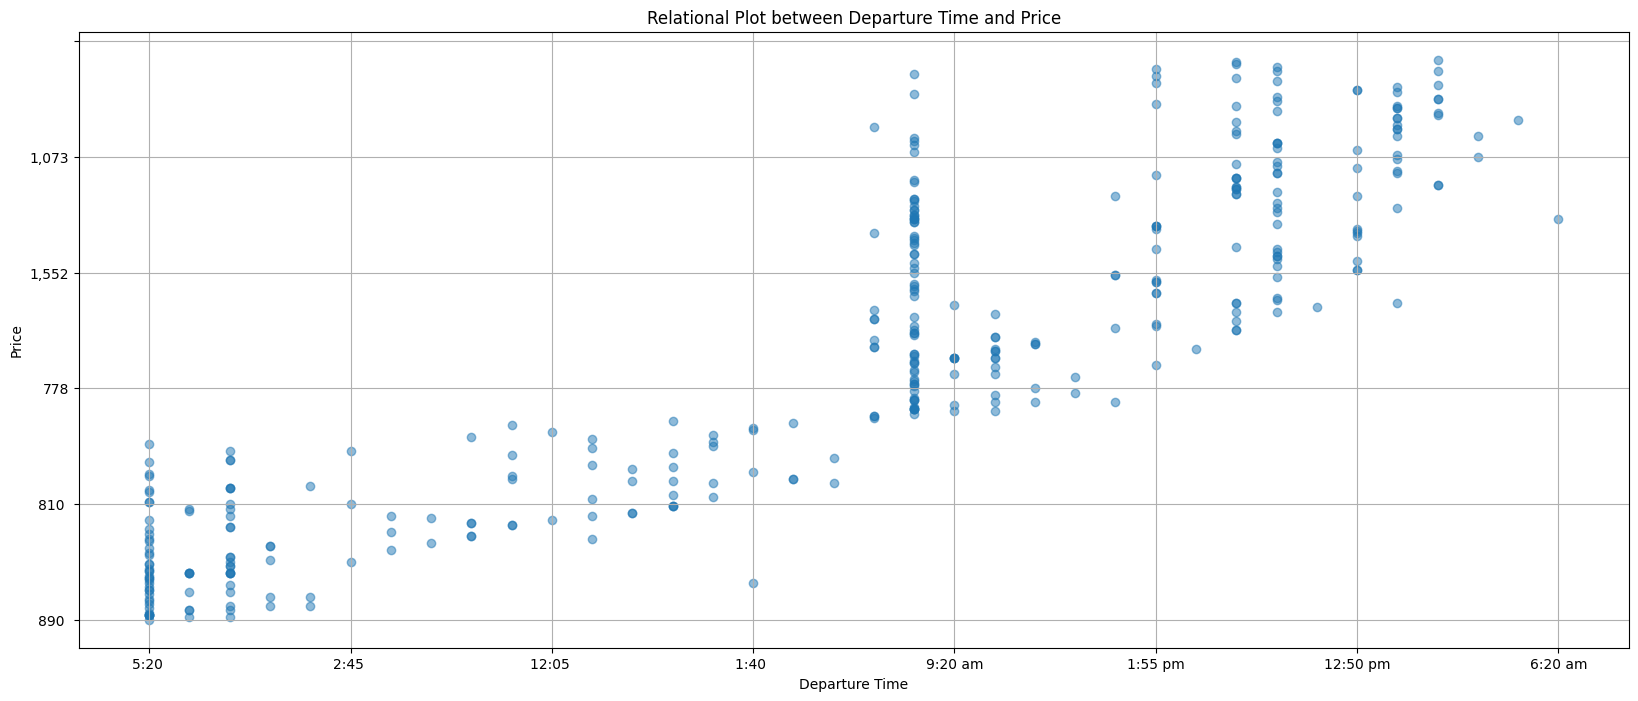

In [26]:
plt.figure(figsize=(20, 8))  # Adjust the figure size as needed
plt.scatter(df[column_x], df[column_y], alpha=0.5)  # Alpha controls transparency
plt.xlabel(column_x)
plt.ylabel(column_y)
plt.yticks(fontsize=10)
plt.title(f'Relational Plot between {column_x} and {column_y}')
plt.grid(True)  # Add grid lines (optional)
plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
plt.gca().xaxis.set_major_locator(ticker.AutoLocator())
plt.show()

**Airlines and layover relate**

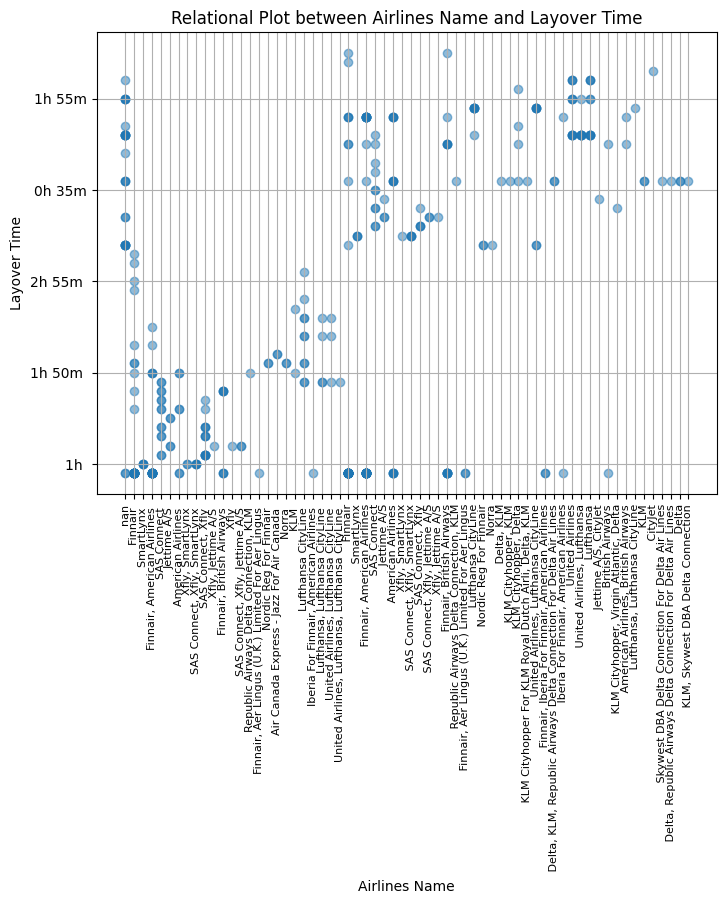

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
df = pd.read_csv('flight.csv')
column1_name = 'Airlines Name'
column2_name = 'Layover Time'

df['Category1_numeric'] = pd.factorize(df[column1_name])[0]
df['Category2_numeric'] = pd.factorize(df[column2_name])[0]
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
plt.scatter(df['Category1_numeric'], df['Category2_numeric'], alpha=0.5)  # Alpha controls transparency
plt.xlabel(column1_name)
plt.ylabel(column2_name)
plt.title(f'Relational Plot between {column1_name} and {column2_name}')
plt.xticks(ticks=df['Category1_numeric'].unique(), labels=df[column1_name].unique(), rotation=90, fontsize=8)
plt.yticks(ticks=df['Category2_numeric'].unique(), labels=df[column2_name].unique())
plt.grid(True)  # Add grid lines (optional)
plt.gca().yaxis.set_major_locator(ticker.AutoLocator())
plt.show()


**User inputs and sorting codes**

In [ ]:
df = pd.read_csv('flightcsv')

column_to_sort = input("Enter the name of the column to sort by: ")
sort_order = input("Enter 'asc' for ascending or 'desc' for descending sort order: ")

# Validate the sort order
if sort_order.lower() not in ['asc', 'desc']:
    print("Invalid input for sort order. Please enter 'asc' or 'desc'.")
else:
    # Perform the sorting based on user input
    if sort_order.lower() == 'asc':
        sorted_df = df.sort_values(by=column_to_sort, ascending=True)
    else:
        sorted_df = df.sort_values(by=column_to_sort, ascending=False)

    # Display the sorted DataFrame
    print(sorted_df)




In [ ]:
# Collect user input for the range
column_name = input("Enter the name of the column to filter by: ")
min_value = float(input("Enter the minimum value of the range: "))
max_value = float(input("Enter the maximum value of the range: "))

# Filter the DataFrame based on the user's input
filtered_df = df[(df[column_name] >= min_value) & (df[column_name] <= max_value)]
print(filtered_df)